In [1]:
import tensorflow as tf
from IPython.display import clear_output
import itertools, re, os, random, keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams
import matplotlib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from pylab import rcParams
from keras.models import Sequential, save_model

from keras.layers import Dense, Activation, Dropout, Flatten, BatchNormalization, Input, concatenate, Reshape, Conv2DTranspose, Conv2D, MaxPool2D, GlobalAveragePooling2D
from keras import layers, Input, Model, models, regularizers, optimizers

from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.utils import np_utils
from sklearn.utils import class_weight
import tensorflow_addons as tfa

from keras.layers.convolutional import Conv1D, Convolution1D, MaxPooling1D

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
import math
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import seaborn as sns
import matplotlib.image as mpimg
import plotly.express as px
from keras.utils.vis_utils import plot_model

from numpy import expand_dims
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
import os
from tensorflow.keras import initializers
import gc
import random
np.set_printoptions(threshold=np.inf)
import math

In [2]:
p=pd.read_csv('../input/hatworkers/Self Driving Car.v3-fixed-small.darknet/export/_darknet.labels', header=None)
print(p.head(50))

                          0
0                     biker
1                       car
2                pedestrian
3              trafficLight
4        trafficLight-Green
5    trafficLight-GreenLeft
6          trafficLight-Red
7      trafficLight-RedLeft
8       trafficLight-Yellow
9   trafficLight-YellowLeft
10                    truck


In [3]:
individual_size=5
sizei=2
total_sizei=25
each_sizei=7
image_size=512
factor=image_size/512
grid_dime = image_size/individual_size

In [4]:
p=pd.read_csv('../input/hatworkers/Self Driving Car.v3-fixed-small.darknet/export/_darknet.labels', header=None)
d={}
for i in range(len(p)):
    d[i]=p[0][i]

In [5]:
from __future__ import division
from collections import Sequence

def get_se(mi,ma,r):
    sampl = np.random.uniform(low=mi, high=ma, size=(r,))
    sampl=sampl.tolist()
    return sampl

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  


In [6]:
p=pd.read_csv('../input/hatworkers/Self Driving Car.v3-fixed-small.darknet/export/_darknet.labels')
print(p.head(50))
global no_of_anchors,no_of_classes,threshold, thresh_iou,max_box
no_of_anchors=7
no_of_classes=len(p)
threshold=0.0
threshold_iou=1.0
max_box=10

                     biker
0                      car
1               pedestrian
2             trafficLight
3       trafficLight-Green
4   trafficLight-GreenLeft
5         trafficLight-Red
6     trafficLight-RedLeft
7      trafficLight-Yellow
8  trafficLight-YellowLeft
9                    truck


In [7]:
def predict(image_file):
    import matplotlib.pyplot as plt
    from matplotlib.patches import Rectangle
    from PIL import Image
    file_name=os.path.splitext(image_file)[0]+'.txt'
    path_csv = pd.read_csv(file_name, sep=" ", header=None)
    path_csv.columns=['label','x','y','w','h']
    im = Image.open(image_file)
    plt.imshow(Image.open(image_file))
    print(im.size)
    plt.grid(True)
    for i in range(len(path_csv)):
        x=path_csv.iloc[i:i+1,:]
        xi=x['x'].values*512
        yi=x['y'].values*512
        wi=x['w'].values*512
        hi=x['h'].values*512
        box_x=xi-(0.5*wi)
        box_y=yi-(0.5*hi)
        la=x['label'].values
        la=d[la[0]]
        text_x=xi-(0.5*wi)
        text_y=yi-(0.5*hi)
        plt.gca().add_patch(Rectangle((box_x, box_y), wi, hi, linewidth=1, edgecolor='r', facecolor='none'))
        plt.text(text_x, text_y, la, fontsize=7, color='b')

(512, 512)


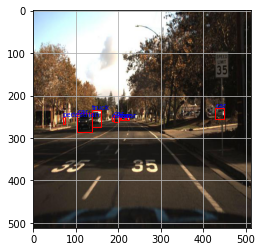

In [8]:
predict('../input/hatworkers/Self Driving Car.v3-fixed-small.darknet/export/1478019957180061202_jpg.rf.cdefcc1c676aa9a6abcacbe79fff26f6.jpg')

(512, 512)


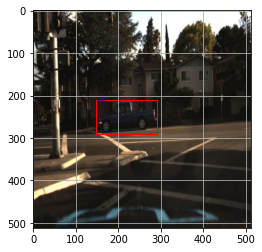

In [9]:
predict('../input/hatworkers/Self Driving Car.v3-fixed-small.darknet/export/1478019978686299906_jpg.rf.bxnJeeEptGCrdAcL9zPM.jpg')

In [10]:
df=pd.DataFrame({
    'x':[0,1,2,3,4,5,6],
    'y':[2,5,3,1,8,0,9]
})

In [11]:
df['x']=df['x']*2
print(df)

    x  y
0   0  2
1   2  5
2   4  3
3   6  1
4   8  8
5  10  0
6  12  9


In [12]:
tensor=[0,0,1,1,0,1,0,1,1]
b=np.array(tensor)
print(tf.boolean_mask(tensor, tensor))

tf.Tensor([1 1 1 1 1], shape=(5,), dtype=int32)


In [13]:
def create_vec(x):
    li=[0.]*(sizei+1)
    li[0]=1.0
    li[x]=1.0
    return li

In [14]:
def create_map(dm):
    result=[]
    dm['r']=dm['x']*image_size
    dm['s']=dm['y']*image_size
    dm['r']=(dm['r']/grid_dime).apply(np.ceil)
    dm['s']=(dm['s']/grid_dime).apply(np.ceil)
    for i in range(1,(individual_size+1)):
        for j in range(1,(individual_size+1)):
            if len(dm.loc[(dm['r'] == i) & (dm['s'] == j)].index)>0:
                result2=[1.0]
                dp = dm.loc[(dm['r'] == i) & (dm['s'] == j)]
                dp=dp.reset_index(drop=True)
                dp=dp.reset_index(drop=True)
                for k in range(min(each_sizei,len(dp))):
                    result3=create_vec(dp['label'][k])
                    result3.extend([dp['x'][k],dp['y'][k],dp['w'][k],dp['h'][k]])
                    result2.extend(result3)
                if (len(dp)<each_sizei):
                    c=get_mi(each_sizei-len(dp))
                    result2.extend(c)
                    result.append(result2)  
                else:
                    result.append(result2)
            else:
                result2=[0.0]
                c=get_mi(each_sizei)
                result2.extend(c)
                result.append(result2)                
    return result             

In [15]:
def get_li(n):
    c=[0.000000]*((each_sizei*(sizei+5))+1)
    #c.extend(get_se(0.0,1.0,15))
    c=[c]*n
    return c

In [16]:
def get_mi(n):
    c=[0.000000]*(sizei+5)
    #c.extend(get_se(0.0,1.0,15))
    c=c*n
    return c

a=tf.random.uniform(
    (19,19,3,6), minval=0, maxval=1, dtype=tf.dtypes.float32, seed=None, name=None
)
initializer = tf.keras.initializers.RandomNormal(stddev=1.0)
a = initializer(shape=(19, 19, 3, 6))
boxes_=a[:,:,:,1:5]
confidence_=a[:,:,:,:1]
classes_=a[:,:,:,5:]
scores,boxes,classes=yolo_filter_boxes(boxes_,confidence_,classes_,threshold)
scores,boxes,classes=yolo_non_max_suppression(scores,boxes,classes,max_box,threshold_iou)

img = mpimg.imread('../input/hatworkers/Self Driving Car.v3-fixed-small.darknet/export/1478899721401166994_jpg.rf.lwYi6ExQ62Wi6iGHEf4a.jpg') 
plt.figure(figsize=(28,20))
plt.imshow(img)

class extra_layer(tf.keras.layers.Layer):
    def __inti__(self, units=32):
        super(extra_layer, self).__init__()
        self.units=units
    def build(self, input_shape):
        w_init=tf.zeros_initializer()
        self.w=tf.Variable(name='kernel',
                          initial_value=w_init(shape=(input_shape[-1], self.units), dtype='float32'),trainable=True
                          )
        b_init=tf.zeros_initializer()
        self.b=tf.Variable(name="bias",
                          initial_value=b_init(shape=(self.units,), dtype='float32'), trainable=True)
    def call(self,inputs):
        return tf.matmul(inputs,self.w)+self.b

df=pd.DataFrame({
'image_path':'a',
'valu':[tf.zeros((75,),dtype=tf.dtypes.float32).numpy()]
 })
 df=df.iloc[1:,:]

 for i in range(10):
     ten=tf.zeros((75,), dtype=tf.dtypes.float32)
     ten=ten.numpy()
     df.loc[len(df.index)]=['a',ten]

y=df.valu

In [17]:
def devil(r): 
    df=pd.DataFrame({
        'image_path':"a",
        'labels':[np.zeros((5,6))]
    })
    df=df.iloc[1:,:]
    asterik=0
    df=df.reset_index(drop=True)
    dat_path="../input/hatworkers/Self Driving Car.v3-fixed-small.darknet/export"
    for file in os.listdir(dat_path):
        if file.endswith(".txt"):
            if(asterik%4==r):
                file_path=dat_path+'/'+file
                file_name=os.path.splitext(file_path)[0]+'.jpg'
                if os.stat(file_path).st_size != 0:
                    path_csv = pd.read_csv(file_path, sep=" ", header=None)
                    path_csv.columns=['label','x','y','w','h']
                    for stu in path_csv.columns[1:]:
                        path_csv[stu]=path_csv[stu].apply(lambda x:x*factor)
                    path_csv=path_csv.loc[(path_csv['label'] ==1) | (path_csv['label'] == 2)] 
                    path_csv['hit']=path_csv['w']*path_csv['h']
                    path_csv = path_csv.sort_values(by=['hit'], ascending=False)
                    path_csv=path_csv.reset_index(drop=True)
                    if(len(path_csv)>0):
                        x=create_map(path_csv)
                        x=np.array(x,dtype=np.float32)
                        x=x.flatten()
                        df.loc[len(df.index)]=[file_name,x]
                    else:
                        x=get_li(total_sizei)
                        x=np.array(x,dtype=np.float32)
                        x=x.flatten()
                        df.loc[len(df.index)]=[file_name,x]
                else:
                    x=get_li(total_sizei)
                    x=np.array(x,dtype=np.float32)
                    x=x.flatten()
                    df.loc[len(df.index)]=[file_name,x] 
            asterik+=1        
    return df

In [18]:
from multiprocessing import Pool
pool = Pool()
jobs=[]
jobs.append(pool.apply_async(devil,[0]))
jobs.append(pool.apply_async(devil,[1]))
jobs.append(pool.apply_async(devil,[2]))
jobs.append(pool.apply_async(devil,[3]))
df=pd.concat([jobs[0].get(),jobs[1].get(),jobs[2].get(),jobs[3].get()])
df=df.reset_index(drop=True)

In [19]:
a=df.to_numpy()

In [20]:
gc.collect()

7396

In [21]:
np.save('goodboy',a)

In [22]:
pool.close()